## Dataset
The dataset is provided by the Robust Medical Instrument Segmentation (ROBUST-MIS) challenge, which is part of the Endoscopic Vision (Endo Vis) challenge, held at International Medical Conference on Medical Image Computing and Computer Assisted Intervention (MICCAI) in 2019. The goal of this competition is to provide practitioners with context-aware intraoperative assistance during robot-assisted surgery. The dataset is collected at Heidelberg University Hospital by ORI FUSION (KARL STORZ SE & Co KG, Tuttlingen, Germany). It consists of 30 laparoscopic videos depicting three types of surgeries: proctocolectomy (removal of the entire colon and rectum), rectal resection (removal of a small portion or the entire rectum), and sigmoid resection (removal of the sigmoid colon)

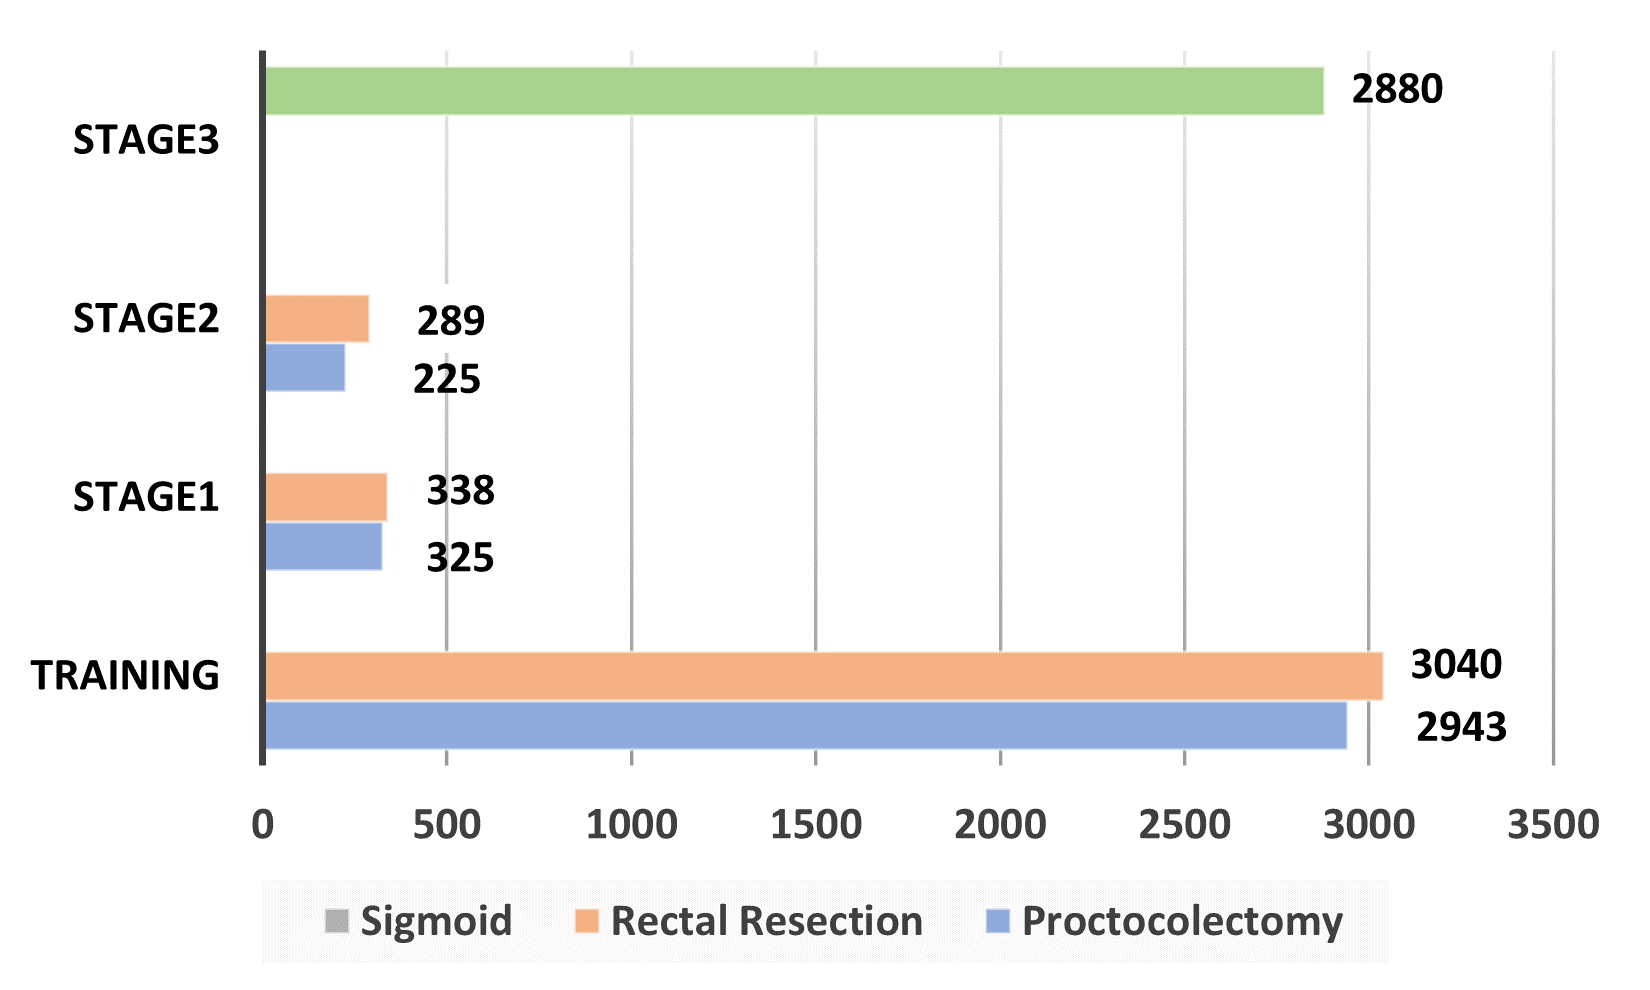

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from Unet_model import Unet
from AttentionUnet_model import Attension_Unet
from Unet_Resnet50_model import Unet_Resnet50
from Unet_VGG16_model import Unet_VGG16

frame_directory='./..'
mask_directory='./..'

frame_list=os.listdir(frame_directory)
mask_list=os.listdir(mask_directory)

seed=24
batch_size=32

def trainGenerator(train_img_path,train_mask_path):
    
    frame_data_gen_args=dict(rescale=1./255,
                           horizontal_flip=True,
                           vertical_flip=True)
    mask_data_gen_args=dict(horizontal_flip=True,
                            vertical_flip=True)
    frame_datagen=ImageDataGenerator(**frame_data_gen_args)
    mask_datagen=ImageDataGenerator(**mask_data_gen_args)
    
    frame_generator=frame_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        color_mode = 'rgb',
        target_size=(240,240),
        batch_size=batch_size,
        seed=seed)
    mask_generator=mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        color_mode = 'grayscale',
        target_size=(240,240),
        batch_size=batch_size,
        seed=seed)
    
    train_generator=zip(frame_generator,mask_generator)
    
    for (frame,mask) in train_generator:
        yield (frame,mask)

train_img_path ='./..'
train_mask_path='./..'

val_img_path='./..'
val_mask_path='./..'

train_img_gen=trainGenerator(train_img_path,train_mask_path)
val_img_gen=trainGenerator(val_img_path,val_mask_path)

num_train_imgs = len(os.listdir('./..'))
num_val_images=len(os.listdir('./..'))
steps_per_epoch=num_train_imgs//batch_size
val_steps_per_epoch=num_val_images//batch_size
x,y=train_img_gen.__next__()
img_height=x.shape[1]
img_width=x.shape[2]
img_channels=x.shape[3]
input_shape=(img_height,img_width,img_channels)

import segmentation_models as sm
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
log_csv = CSVLogger('./unet_logs.csv', separator=',', append=False)
callbacks_list = [early_stop, log_csv]


model=Unet(input_shape)
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
model.summary()

Found 0 images belonging to 1 classes.
Found 0 images belonging to 1 classes.
Segmentation Models: using `keras` framework.
Model: "UNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 240, 240, 3) 0                                            
__________________________________________________________________________________________________
B1_Conv1 (Conv2D)               (None, 240, 240, 64) 1792        Input[0][0]                      
__________________________________________________________________________________________________
B1_Conv1_BatchNormalization (Ba (None, 240, 240, 64) 256         B1_Conv1[0][0]                   
__________________________________________________________________________________________________
B1_Conv1_Activation (Activation (None, 240, 240, 64) 0           B1_Co

In [ ]:
start_time = time.time()
history=model.fit(train_img_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=100,
          verbose=1,
          validation_data=val_img_gen,
          validation_steps=val_steps_per_epoch,
          callbacks=callbacks_list)
model.save('./unet.hdf5')
elapsed_time = time.time() - start_time
print('{:02f}:{:02f}:{:02f}'.format(elapsed_time // 3600, (elapsed_time % 3600 // 60), elapsed_time % 60))

In [ ]:
from keras.models import load_model
model = load_model("./unet.hdf5", compile=False)
test_image_batch, test_mask_batch = val_img_gen.__next__()
test_img_number = random.randint(0, len(test_image_batch)-1)
test_img = test_image_batch[test_img_number]
ground_truth=test_mask_batch[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Test Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Test Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Predicted Test Image')
plt.imshow(prediction, cmap='gray')

# IoU calculation
intersection = np.logical_and(ground_truth[:,:,0], prediction)
iou_score = np.sum(intersection) / ((np.sum(ground_truth[:,:,0])+np.sum(prediction))- np.sum(intersection))
print('IoU is %s' % iou_score)

# dice_coeff
intersection = np.logical_and(ground_truth[:,:,0], prediction)
dice_coeff=(2*np.sum(intersection))/(np.sum(ground_truth[:,:,0])+np.sum(prediction))
print('dice_coeff is %s'% dice_coeff)

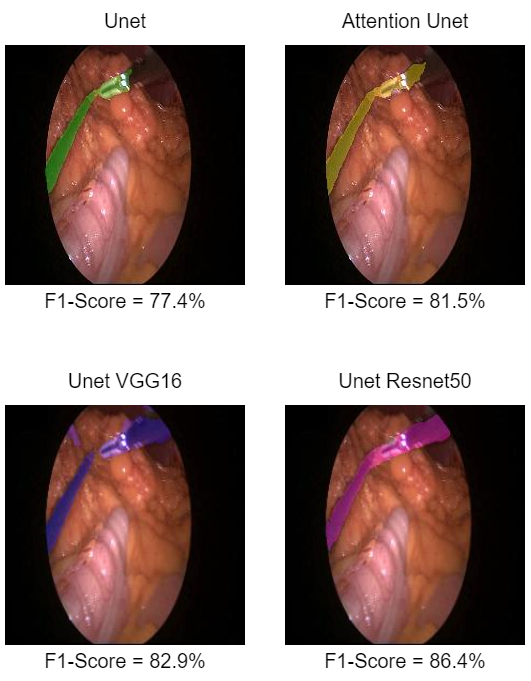